In [1]:
# !pip install pandas
# !pip install torch
# !pip install tqdm  # pip install ipywidgets or something
!pip install wandb &> /dev/null
# !pip install gensim &> /dev/null
!pip install torchmetrics &> /dev/null

In [2]:
USING_WANDB = True  # Set to false if not Peter

if USING_WANDB:
    import wandb
    wandb.login();
    # !wandb login

wandb: Currently logged in as: petern0408. Use `wandb login --relogin` to force relogin


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
data_folder = "/content/drive/MyDrive/dna_ml_model_data"
accessible_file = f"{data_folder}/accessible.fasta"
notaccessible_file = f"{data_folder}/notaccessible.fasta"
reduced_nonaccessible_file = f"{data_folder}/reduced_nonaccessible.fasta"
comp_file = f"{data_folder}/test.fasta"
rest_notaccessible_file = f"{data_folder}/rest_nonaccessible.fasta"

DATA_ZIP_FILE = "Files.zip"
LINES_PER_SEQUENCE = 4
ACCESSIBLE_LABEL = 1
NOT_ACCESSIBLE_LABEL = 0
TEMP_SPLIT = 0.30  # validation + test
TEST_SPLIT = 0.15
PRETRAINED_DIR = "pretrained"
SOLUTION_FILE = "predictions.csv"

In [5]:
import dna_dataset, utils, CNNModel # , LSTMCNNModel, constants
import torch.nn as nn, torch.optim as optim, torch
from tqdm.notebook import tqdm
import importlib, os, numpy as np, pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from torchmetrics.functional import f1_score
from sklearn.metrics import confusion_matrix, precision_recall_curve

importlib.reload(dna_dataset)
importlib.reload(utils)
importlib.reload(CNNModel)
# importlib.reload(LSTMCNNModel)
# importlib.reload(constants)

<module 'CNNModel' from '/content/CNNModel.py'>

In [ ]:
# Unzip the zip file
!unzip $DATA_ZIP_FILE

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
# Read the data from data files
acc_sequences, acc_labels, _ = dna_dataset.read_data_file(accessible_file, accessible=True, shuffle=True)
# not_sequences, not_labels, _ = dna_dataset.read_data_file(reduced_nonaccessible_file, accessible=False, shuffle=True)

In [ ]:
not_sequences, not_labels, _ = dna_dataset.read_data_file(notaccessible_file, accessible=False, shuffle=True)

In [9]:
num_acc = len(acc_sequences)
num_not = len(not_sequences)
full_size = num_acc + num_not

# Split accessible data into train val test split
acc_seq_train, acc_seq_temp, acc_lab_train, acc_lab_temp = train_test_split(acc_sequences, acc_labels, test_size=TEMP_SPLIT, random_state=1)
acc_seq_val, acc_seq_test, acc_lab_val, acc_lab_test = train_test_split(acc_seq_temp, acc_lab_temp, test_size=TEST_SPLIT/TEMP_SPLIT, random_state=1)

# Split not accessible data into train val test split
not_seq_train, not_seq_temp, not_lab_train, not_lab_temp = train_test_split(not_sequences, not_labels, test_size=TEMP_SPLIT, random_state=1)
not_seq_val, not_seq_test, not_lab_val, not_lab_test = train_test_split(not_seq_temp, not_lab_temp, test_size=TEST_SPLIT/TEMP_SPLIT, random_state=1)

# assert(self.accessible_count + self.not_accessible_count == len(self.sequences))
assert(len(acc_sequences) == len(acc_labels) == len(acc_seq_train) + len(acc_seq_val) + len(acc_seq_test))
assert(len(not_sequences) == len(not_labels) == len(not_lab_train) + len(not_lab_val) + len(not_lab_test))

Upsample or Downsample the dataset  
(AFTER splitting to train/validation/test to prevent data leakage)

In [ ]:
UPSAMPLE = False
DOWNSAMPLE = True


if UPSAMPLE:
    num_diff = len(not_seq_train) - len(acc_seq_train)
    # upscale the minority
    upsampled_acc_seq, upsampled_acc_lab = resample(acc_seq_train, acc_lab_train, n_samples=num_diff, random_state=1)
    acc_seq_train += upsampled_acc_seq
    acc_lab_train += upsampled_acc_lab

elif DOWNSAMPLE:
    # downsample the majority
    downsampled_not_seq, downsampled_not_lab = resample(not_seq_train, not_lab_train, n_samples=len(acc_seq_train), random_state=1)
    # just take the first part len(acc_seq_train) samples
    # downsampled_not_seq, downsampled_not_lab = not_seq_train[:len(acc_seq_train)], not_lab_train[:len(acc_seq_train)]
    not_seq_train += downsampled_not_seq
    not_lab_train += downsampled_not_lab

    # consider upweighting for calibration

    # consider adding rest of data to test and val
    # rest_not_sequences, rest_not_labels = not_seq_train[len(acc_seq_train):], not_lab_train[:len(acc_seq_train):]

print(len(acc_seq_train), len(acc_lab_train))
assert(len(acc_seq_train) == len(acc_lab_train))  # ensure the data is now equal

In [10]:
# Create the (shuffled) datasets, after appending the lists
sequences_train = acc_seq_train + not_seq_train
labels_train = acc_lab_train + not_lab_train
# sequences_train, labels_train = dna_dataset.shuffle_lists(sequences_train, labels_train)
# df_train = pd.DataFrame({"sequences": sequences_train, "labels": labels_train})
train_dataset = dna_dataset.DNADataset(sequences_train, labels_train)
num_train = len(train_dataset)
assert(len(sequences_train) == len(labels_train) == num_train)

sequences_val = acc_seq_val + not_seq_val
labels_val = acc_lab_val + not_lab_val
# sequences_val, labels_val = dna_dataset.shuffle_lists(sequences_val, labels_val)
# df_val = pd.DataFrame({"sequences": sequences_val, "labels": labels_val})
val_dataset = dna_dataset.DNADataset(sequences_val, labels_val)

sequences_test = acc_seq_test + not_seq_test
labels_test = acc_lab_test + not_lab_test
# sequences_test, labels_test = dna_dataset.shuffle_lists(sequences_test, labels_test)
# df_test = pd.DataFrame({"sequences": sequences_test, "labels": labels_test})
test_dataset = dna_dataset.DNADataset(sequences_test, labels_test)

# assert(len(sequences_train) + len(sequences_val) + len(sequences_test) == full_size)
# full_dataset = dna_dataset.DNADataset(accessible_file, reduced_nonaccessible_file)

In [11]:
# ensure the DNADataset is loaded properly
print('total sequences', full_size)
print('num accessible', num_acc)
print('num not accessible', num_not)
i = 0
print(f"example entry {i}")
item = train_dataset[i]
# print(item['sequence'])  # long answer
print("label", item['label'])
# ensure dataset was shuffled properly
# check that not all the accessible labels are at the front
for i in range(len(train_dataset)):
    if train_dataset[i]['label'] != ACCESSIBLE_LABEL:
        print('shuffled')
        break

# Balanced: total sequences 94478  num accessible 47239  num not accessible 47239

# Full (imbalanced) total sequences 525688  num accessible 47239  num not accessible 478449

total sequences 94478
num accessible 47239
num not accessible 47239
example entry 0
label 0
shuffled


In [ ]:
# # Free up memory
# del sequences_train, labels_train, sequences_val, labels_val, sequences_test, labels_test
# del acc_seq_train, not_seq_train, acc_lab_train, not_lab_train
# del acc_seq_val, not_seq_val, acc_lab_val, not_lab_val
# del acc_seq_test, not_seq_test, acc_lab_test, not_lab_test

In [12]:
# Initialize model
importlib.reload(CNNModel)
torch.manual_seed(0)

kernel_size = 3     # 2  # should use odd size
embed_dim = 4  # 4
num_filters1 = 64  # 128
num_filters2 = 128  # 64
pool_kernel_size = 2  # 2
hidden_dense1 = 64  # 128
hidden_dense2 = 32  # 64
dropout_rate_Dense = 0.5  # .5

# insert torch model here, that takes sequence as input and output a label 0 or 1
model = CNNModel.CNNModel(kernel_size,
                           embed_dim,
                           num_filters1,
                           num_filters2,
                           pool_kernel_size,
                           hidden_dense1,
                           hidden_dense2,
                           dropout_rate_Dense
                           )

model.to(device);  # quiet output

In [13]:
# weights for loss function
USE_WEIGHTED_LOSS = False  # Note may not work correctly if used with resampling
# USE_WEIGHTED_LOSS = False

# weight_for_class_i = total_samples / (num_samples_in_class_i * num_classes)
weight_class0 = num_train / len(acc_seq_train) * 2
weight_class1 = num_train / len(not_seq_train) * 2
print("weights for class 0", weight_class0)
print("weights for class 1", weight_class1)

weights for class 0 4.0
weights for class 1 4.0


In [14]:
# parameters
epochs = 20
batch_size = 64
learning_rate = .0001
if USE_WEIGHTED_LOSS:
    loss_fn = nn.BCELoss()
    # loss_fn = nn.BCEWithLogitsLoss()
    # loss_fn = nn.BCELoss(weight=torch.Tensor([weight_class0, weight_class1]))
else:
    loss_fn = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)  # weight_decay=1
# optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=.01)  # weight_decay=1
# optimizer = optim.SGD(model.parameters(), lr=learning_rate)  # pretty bad

In [15]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, # shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, # shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, # shuffle=True
)

In [92]:
# del train_dataset, val_dataset, test_dataset

In [93]:
# USING_WANDB = True

In [16]:
# TRAINING LOOP
# USING_WANDB = False
if USING_WANDB:
    note = f"reduced data"
    # note = f"{optimizer.__class__.__name__}-{kernel_size}-kernel-{num_filters1}-{num_filters2}-conv-{hidden_dense1}-{hidden_dense2}-dense" # "lstm_no_dropout" # "0.5_dropout"
    wandb.init(
        project="dna_ml_model",
        # name=f"experiment_{run}"
        name=f"{note}",
        settings=wandb.Settings(start_method="fork"),
        config = {
            "architecture": model.__class__.__name__,
            "epochs": epochs,
            "learning_rate": learning_rate,
            "batch_size": batch_size,
            "optimizer": optimizer.__class__.__name__,
            "notes": note
    })


# step = 0
best_acc = 0.0

for epoch in range(epochs):
    print(f"Epoch {epoch + 1} of {epochs}")

    running_loss = 0.0
    running_corrects = 0.0
    # total_outputs = torch.empty(0).to(device)
    # total_labels = torch.empty(0).to(device)

    CM = 0  # confusion matrix

    model.train()
    for batch in train_loader:  # tqdm()
        # Forward propagate
        samples, labels = batch["sequence"].to(device), batch['label'].to(device)

        outputs = model(samples).flatten()

        labels = labels.reshape(-1,1).float().flatten()

        # Backpropagation and gradient descent

        if USE_WEIGHTED_LOSS:
            acc_weight = (labels==ACCESSIBLE_LABEL) * weight_class0
            not_weight = (labels==NOT_ACCESSIBLE_LABEL) * weight_class1
            acc_weight[acc_weight==0] = 1
            not_weight[not_weight==0] = 1

            outputs *= acc_weight
            outputs *= not_weight

        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()  # reset gradients before next iteration

        running_loss += loss.item() * samples.size(0)  # loss per sample times batch size

        preds = utils.get_preds(outputs)
        running_corrects += torch.sum(preds == labels.data).item()
        # print(outputs.shape, preds.shape)
        CM += confusion_matrix(labels.flatten().detach().numpy(), preds.flatten().detach().numpy())

    #     total_outputs = torch.cat((total_outputs, outputs))
    #     total_labels = torch.cat((total_labels, labels))
    # f1 = f1_score(total_outputs.flatten(), total_labels.flatten(), task="binary", num_classes=2).item()

    # Calculate recall, precision, f1 score
    acc_score, precision, recall, f1 = utils.compute_metrics(CM)

    # if step % n_eval == 0:
    # Compute training loss and accuracy.
    with torch.no_grad():
        model.eval()
        # Compute validation loss and accuracy.
        # accuracy = utils.compute_accuracy(outputs, labels)  # only does current batch
        val_loss, val_acc, val_precision, val_recall, val_f1 = utils.evaluate(val_loader, model, loss_fn, device)

    epoch_loss = running_loss / num_train
    epoch_acc = running_corrects / num_train
    print(f"""Training Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {f1:.4f}
          Precision {precision:.4f} Recall: {recall:.4f}""")
    print(f"""Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f} F1: {val_f1:.4f}
          Precision {val_precision:.4f} Recall: {val_recall:.4f}""")

    # # deep copy the model
    # if val_accuracy > best_acc:
    #     best_acc = epoch_acc
    #     torch.save(model.state_dict(), best_model_params_path)

    if USING_WANDB:
        wandb.log({"Train Loss": epoch_loss,
                    "Train Acc": epoch_acc,
                    "Val Loss": val_loss,
                    "Val Acc": val_acc,
                    "Train Precision": precision,
                    "Val Precision": precision,
                    "Train F1": f1,
                    "Val F1": val_f1
                  #  "Epoch": epoch
        })
        # step += 1

    print()

wandb: Currently logged in as: petern0408. Use `wandb login --relogin` to force relogin


Epoch 1 of 20
Training Loss: 0.6411 Acc: 0.5937 F1: 0.4605
          Precision 0.6850 Recall: 0.3468
Validation Loss: 131.2078 Acc: 0.7062 F1: 0.7009
          Precision 0.7137 Recall: 0.6885

Epoch 2 of 20
Training Loss: 0.6236 Acc: 0.6066 F1: 0.4822
          Precision 0.7053 Recall: 0.3663
Validation Loss: 127.7263 Acc: 0.7362 F1: 0.7592
          Precision 0.6983 Recall: 0.8318

Epoch 3 of 20
Training Loss: 0.6084 Acc: 0.6200 F1: 0.5049
          Precision 0.7243 Recall: 0.3875
Validation Loss: 125.0140 Acc: 0.7449 F1: 0.7703
          Precision 0.7007 Recall: 0.8552

Epoch 4 of 20
Training Loss: 0.6010 Acc: 0.6260 F1: 0.5132
          Precision 0.7350 Recall: 0.3943
Validation Loss: 122.7360 Acc: 0.7449 F1: 0.7757
          Precision 0.6922 Recall: 0.8822

Epoch 5 of 20
Training Loss: 0.5941 Acc: 0.6276 F1: 0.5139
          Precision 0.7397 Recall: 0.3937
Validation Loss: 119.2265 Acc: 0.7499 F1: 0.7782
          Precision 0.6991 Recall: 0.8775

Epoch 6 of 20
Training Loss: 0.5915

In [23]:
# wandb.finish()

<ipython-input-21-e7ea5901af13>:29: RuntimeWarning: invalid value encountered in divide
  fscores = (2 * precisions * recalls) / (precisions + recalls)


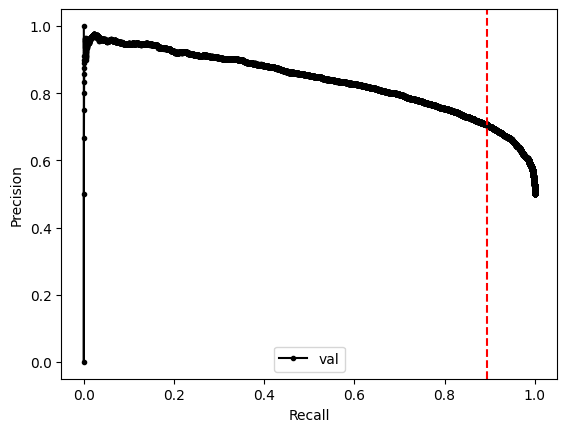

Best Threshold 0.4274745285511017  with F-Score 0.7895359701027717


In [21]:
# Precision recall plot for finding optimal threshold

import matplotlib.pyplot as plt
which_dataset = "val"  # test
# which_dataset = "test"
dataset = val_dataset if which_dataset == "val" else test_dataset
dataloader = val_loader if which_dataset == "val" else test_loader

total_probs = np.empty(0)
model.eval()
# Calculate the probs
for batch in dataloader:
    samples, labels = batch['sequence'].to(device), batch['label'].to(device)

    outputs = model(samples)

    total_probs = np.concatenate((total_probs, outputs.flatten().detach().numpy()))


precisions, recalls, thresholds = precision_recall_curve(dataset.list2, total_probs)
# dataset.list2  # list of all labels

plt.plot(recalls, precisions, marker='.', label=which_dataset, color="black")
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
fscores = (2 * precisions * recalls) / (precisions + recalls)

# Turn nan values to 0
fscores[np.isnan(fscores)] = 0

# locate the index of the largest f score
ix = np.argmax(fscores)
best_threshold = thresholds[ix]
plt.plot(recalls[ix], precisions[ix], color="red")
plt.axvline(recalls[ix], ls='--', color="red", label="Best F-Score")
# show the plot
plt.show()
print("Best Threshold", thresholds[ix], " with F-Score", fscores[ix])
# Best Threshold 42.7

In [23]:
# EVALUATE on test dataset
total_predictions = 0
total_correct = 0

model.eval()

CM = 0  # confusion matrix

for batch in test_loader:  # tqdm()

    test_samples, test_labels = batch['sequence'].to(device), batch['label'].to(device)
    test_outputs = model(test_samples)
    test_preds = utils.get_preds(test_outputs)

    test_labels = test_labels.reshape(-1, 1).float()

    test_loss = loss_fn(test_outputs, test_labels).item()  # change tensor to single val

    total_correct += (test_preds == test_labels).sum().item()

    total_predictions += len(test_outputs)

    CM += confusion_matrix(test_labels.flatten().detach().numpy(), test_preds.flatten().detach().numpy())

# Computer accuracy, precision, recall, and f1 metrics
tn, tp, fp, fn = CM[0][0], CM[1][1], CM[0][1], CM[1][0]  # true negative, ... false positive, etc
acc_score = (tp + tn)/ (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * precision * recall / (precision + recall)


# model.train()
test_accuracy = total_correct / total_predictions
assert(test_accuracy == acc_score)
# test_f1_score = f1_score(total_outputs.flatten(), total_labels.flatten(), task="binary", num_classes=2).item()
print(f"Final Test Accuracy: {test_accuracy * 100} %")
print(f"Final Test Precision: {precision * 100} %")
print(f"Final Test Recall: {recall * 100} %")
print(f"Final Test F1 Score: {f1 * 100} %")

if USING_WANDB:
    wandb.summary['test_accuracy'] = test_accuracy
    wandb.summary['test_precision'] = precision
    wandb.summary['test_recall'] = recall
    wandb.summary['test_f1_score'] = f1

    # wandb.finish()

Final Test Accuracy: 75.94552639006493 %
Final Test Precision: 70.34414075467522 %
Final Test Recall: 89.71210838272651 %
Final Test F1 Score: 78.85629225330273 %


In [ ]:
# from sklearn.metrics import roc_curve, plot_roc_curve,


In [ ]:
# Potential solutions to out of gpu memory
# import gc
# gc.collect()

# with torch.no_grad():
#     torch.cuda.empty_cache()
# torch.cuda.memory_summary(device=None, abbreviated=False)

# del total_outputs, total_labels

In [27]:
# test on rest of nonaccessible
# rest_not_sequences, rest_not_labels, _ = dna_dataset.read_data_file(rest_notaccessible_file, accessible=False, shuffle=True)

In [28]:
rest_nonacc_dataset = dna_dataset.DNADataset(rest_not_sequences, rest_not_labels)
rest_nonacc_loader = torch.utils.data.DataLoader(rest_nonacc_dataset, batch_size=batch_size)#, shuffle=True)

In [ ]:
# test on rest of nonaccessible
total_probs = torch.empty(0)  # tuples of probability, id

model.eval()

for batch in rest_nonacc_loader:  # tqdm()
    samples, _ = batch["sequence"].to(device), batch['label']  # know it's all 0 labels
    outputs = model(samples)

    total_probs = torch.cat((total_probs, outputs))
    # out_list = outputs.tolist()
    # for i in range(len(out_list)):
    #     probs_out.append(out_list[i])

# falses = len(probs_out[probs_out<0.5])  # corrects
preds = utils.get_preds(total_probs)
corrects = len(preds[preds==NOT_ACCESSIBLE_LABEL])
print("correctly predicted ", corrects, " non_accessible values out of ", len(total_preds), " total")
rest_non_correct = corrects / len(total_preds)

print(rest_non_correct, " correct (all not accessible)")

# wandb.summary['rest_nonacc_accuracy'] = rest_non_correct

# wandb.finish()

Save Model

In [ ]:
# Create pretrained directory if not yet created
if not os.path.isdir(PRETRAINED_DIR):
    os.mkdir(PRETRAINED_DIR)

now = datetime.now()
datetime_str = now.strftime("%m-%d-%H-%M-%S")
model_save_path = os.path.join(
    PRETRAINED_DIR,
    f'{note}{datetime_str}-{model.__class__.__name__}-model-{learning_rate}lr-{epochs}epochs.pt'
)
print('model_save_path', model_save_path)
CNNModel.save_CNNModel(model_save_path, model)
print(f"model saved at {datetime_str}")

model_save_path pretrained/proper_rest_notacc01-04-20-24-24-CNNModel-model-0.0001lr-20epochs.pt
model saved at 01-04-20-24-24


Load Model

In [ ]:
model_save_path = "/content/pretrained/proper_rest_notacc01-04-20-24-24-CNNModel-model-0.0001lr-20epochs.pt"
model = CNNModel.load_CNNModel(model_save_path)
model.to(device);

Inference on Competition File

In [ ]:
# Load Competitation Data
# Set shuffle=False to save time, unnecessary for comp file
comp_sequences, _, comp_ids = dna_dataset.read_data_file(comp_file, labeled=False, shuffle=False)
competition_dataset = dna_dataset.DNADataset(comp_sequences, comp_ids, comp=True)
competition_loader = torch.utils.data.DataLoader(
    competition_dataset, batch_size=batch_size, # shuffle=True
)
print("Competition dataset loaded.")

Competition dataset loaded.


In [ ]:
probs = []  # tuples of probability, id

model.eval()
for batch in competition_loader:  # tqdm()

    samples, ids = batch["sequence"].to(device), batch['id']  # not a tensor

    outputs = model(samples)

    out_list = outputs.tolist()

    for i in range(len(out_list)):
        probs.append((out_list[i], ids[i]))

print("Finished inference")

Finished inference


In [ ]:
# View the results
np_probs = np.array(list(zip(*probs))[0])
print("Predicted", len(np_probs[np_probs>0.5]), "true values out of ", len(np_probs), " total")
not_zero = np_probs[np_probs<=0.5]
not_zero.sort()
not_one = np_probs[np_probs>0.5]
not_one[::-1].sort()
print("not accessible probs", not_zero)
print("accessible probs", not_one)

# print(np_probs[np_probs>0.0 and np_probs<1.0])

Predicted 86495 true values out of  269315  total
not accessible probs [7.72003546e-07 1.22001074e-06 1.32544631e-06 ... 4.99994636e-01
 4.99995589e-01 4.99998689e-01]
accessible probs [0.99668294 0.99629837 0.99512321 ... 0.500009   0.50000852 0.50000155]


In [ ]:
probs.sort(reverse=True)
print("first 10\n", list(zip(*probs[:10]))[0])
print("last 10 of top 10000\n", list(zip(*probs[9990:10000]))[0])  # probs only

highest_probs = probs[:10000]  # top 10,000

with open(SOLUTION_FILE, "w") as f:
    for pair in highest_probs:
        f.write(pair[1])
        # f.write("a")
        f.write("\n")

first 10
 ([0.9966829419136047], [0.9962983727455139], [0.9951232075691223], [0.99391770362854], [0.9935550093650818], [0.9931140542030334], [0.9928942322731018], [0.9927329421043396], [0.9923359751701355], [0.9920458793640137])
last 10 of top 10000
 ([0.8520146012306213], [0.852008044719696], [0.8520078063011169], [0.8519814610481262], [0.8519793152809143], [0.8519764542579651], [0.8519759178161621], [0.8519702553749084], [0.8519678115844727], [0.8519659042358398])


In [ ]:
zip_file_name = "predictions.zip"
!zip $zip_file_name $SOLUTION_FILE

  adding: predictions.csv (deflated 65%)


In [ ]:
# ONLY for use on google colab. download files
from google.colab import files
import os
dir = 'pretrained'
model_file = os.path.join(dir, os.listdir(dir)[0])
files.download(model_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download(zip_file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>